In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2
from importlib import reload
import pickle
import PIL

In [22]:
os.chdir('/Volumes/Encrypted/Semiology-Visualisation-Tool/')
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis.crosstab.mega_analysis import exclusions
from mega_analysis import Sankey_Functions
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES import NORMALISE_TO_LOCALISING_VALUES
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items

In [4]:
from scripts.figures import interogate_queries, labels
from scripts.figures  import plotter

# Define lists & file paths

In [5]:
from pathlib import Path
# Define paths
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = excel_path
with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
region_names = labels.get_region_names()

In [171]:
semiology_list = list(recursive_items(SemioDict))

# Get df from Excel sheet & query df

If previously run notebook, get pickled results of MEGA_ANALYSIS, QUERY_SEMIOLOGY, normalisatione etc, and then go straight to Get sorted list of semiologies

In [9]:
with open('scripts/figures/query_results_pickle_re.pkl', 'rb') as f:
    query_results = pickle.load(f)
    
with open('scripts/figures/all_dfs_pickle_re.pkl', 'rb') as f:
    all_dfs = pickle.load(f)

If no pickle available, run:

In [8]:
# Exclude data = True
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database,
                              exclude_data=True)
print(original_df.shape)

(2486, 121)


In [9]:
redistribution_spec = {
    'FT': ['FL', 'INSULA', 'Lateral Temporal', 'TL'],
    'TO': ['Lateral Temporal', 'TL', 'OL'],
    'TP': ['Lateral Temporal', 'TL', 'PL'],
    'FTP': ['INSULA', 'Lateral Temporal', 'TL', 'FL', 'PL'],
    'TPO Junction': ['Lateral Temporal', 'TL', 'PL', 'OL'],
    'PO': ['PL', 'OL'],
    'FP': ['FL', 'PL'],
    'Perisylvian': ['INSULA', 'Lateral Temporal', 'TL', 'FL', 'PL'],
    'Sub-Callosal Cortex': ['Ant Cing (frontal, genu)', 'CING']
}

In [10]:
redistributed_df = copy.deepcopy(original_df)
for from_region, destination_regions in redistribution_spec.items():
    for destination in destination_regions:
        redistributed_df[destination] = original_df[destination].fillna(0) + original_df[from_region].fillna(0)
redistributed_df = redistributed_df.drop(redistribution_spec.keys(), 'columns')

In [11]:
region_names.keys()

dict_keys(['all', 'top_level', 'of_interest', 'of_interest_minus_tl', 'top_level_all_other', 'top_level_temporal', 'low_level_temporal_all', 'low_level_temporal_of_interest'])

In [60]:
region_names_re = region_names
region_names_re['top_level'] =  ['TL',
                     'FL',
                     'CING',
                     'PL',
                     'OL',
                     'INSULA',
                     'Hypothalamus',
                     'Cerebellum',]
region_names_re['top_level_all_other'] = ['Cerebellum']

In [15]:
def query_semiology_wrapper(df, semiology_list, semiology_dict_path):
    query_results = {}
    for semiology in semiology_list:
        query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                     semiology_term=semiology,
                                                                     ignore_case=True,
                                                                     semiology_dict_path=semiology_dict_path,
                                                                     all_columns_wanted = True)
                                                                             # col1=col1, col2=col1)
            
        one_query_result = {
            'query_inspection': query_inspection,
            'num_query_lat': num_query_lat,
            'num_query_loc': num_query_loc
        }
        query_results[semiology] = one_query_result
    return query_results

In [25]:
from mega_analysis.crosstab.mega_analysis.exclusions import exclude_ET, exclude_cortical_stimulation, exclude_spontaneous_semiology, exclude_postictals 

df = copy.deepcopy(exclude_postictals(redistributed_df))
df_SS = exclude_ET(df)
df_SS = exclude_cortical_stimulation(df_SS)
df_TS = exclude_spontaneous_semiology(df)

all_dfs = {
    'full': df,
    'spontaneous': df_SS,
    'topology':  df_TS,
}

In [26]:
query_results = {}
for key, df in all_dfs.items():
    query_results[key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [377]:
with open('scripts/figures/query_results_pickle_re.pkl', 'wb') as f:
    pickle.dump(query_results, f)
with open('scripts/figures/all_dfs_pickle_re.pkl', 'wb') as f:
    pickle.dump(all_dfs, f)

# Get sorted list of semiologies

In [263]:
def sort_semiologies_by_n(query_result, top_n = 0, include_n = False):
    """
    Get semiologies in order of most frequently seen, based on query results
    
    Input:
    - query_results: a dictionary where keys are semiologies and values are
    'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
    (often query_results['not_normalised']['full'])
    - top_n can be used to get the n semiologies with the highest number of cases
    - include_n = True to return the frequency of each semiology
    """
    n_results = []
    for k, v in query_result.items():
        n_results.append(v['num_query_loc'])
    n_results = np.array(n_results)
    
    labels = list(query_result.keys())
    sorted_result = np.sort(n_results)
    sorted_index = np.argsort(n_results)
    sorted_labels = [labels[i] for i in sorted_index]
    if include_n:
        return tuple(zip(sorted_labels[-top_n:], sorted_result[-top_n:]))
    else:
        return sorted_labels[-top_n:]

In [28]:
sorted_semiologies = sort_semiologies_by_n(query_results['full'])

In [265]:
# ali

# find all semiologies that occur more than 100 times in all and SS (localising as above, not datapoints)

#factor function
def semio_frequencies(dict_of_df, no_patients=120):
    i = 0
    j = 0
    full_semio = []
    full_loc_values = []
    full_semio_df = pd.DataFrame(columns=['Semiology', 'Localising'])
    for semio in dict_of_df.keys():
        n_localising = dict_of_df[semio]['num_query_loc']
        full_loc_values.append(n_localising)
        full_semio_df.loc[j, 'Semiology'] = semio
        full_semio_df.loc[j, 'Localising'] = n_localising
        j += 1
        if n_localising > no_patients:  # 410 for top 12
            i += 1
            # print(semio) 
            full_semio.append(semio)
    full_semio_df.set_index('Semiology', inplace=True)
    full_semio_df.sort_values(by=['Localising'], ascending=False, inplace=True)
    return full_semio, full_loc_values, full_semio_df

no_patients = 100

# all data
full_semio, full_loc_values, full_semio_df = semio_frequencies(query_results['full'], no_patients=0)

# spontaneous SS data
SS_semio, SS_loc_values, SS_semio_df = semio_frequencies(query_results['spontaneous'], no_patients=no_patients)

# topological TS data
TS_semio, TS_loc_values, TS_semio_df = semio_frequencies(query_results['topology'], no_patients=no_patients)


over_100 = [i for i in SS_semio if i in full_semio and i in TS_semio]
print (len(over_100))
semiologies_100 = over_100

12


13794.0
3522.0
9930.0


/Users/karan/anaconda3/envs/semiology-vis/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


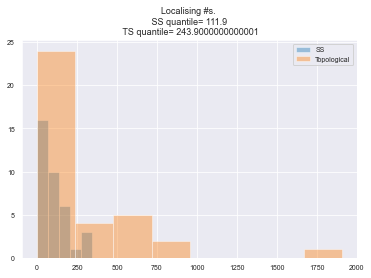

In [266]:
# ali: justification for using top occuring semiologies

print(np.sum(full_loc_values))
print(np.sum(SS_loc_values))
print(np.sum(TS_loc_values))

a = np.quantile(SS_loc_values, 0.66)
b = np.quantile(TS_loc_values, 0.66)

sns.distplot(SS_loc_values, kde=False, label='SS')
sns.distplot(TS_loc_values, kde=False, label='Topological')
plt.legend()
plt.title(f"Localising #s. \n SS quantile= {a} \n TS quantile= {b}")
plt.show()

# if we want to see the top 3rd of the most frequently occuring semiologies that occur in both spontaneous and topological studies, we use >104 for SS and >176 for TS.
# this gives us 10 semiologies rather than 12 above. the two differences are somatosensory and Vocalisation - so by showing the these 12 that occur more than 100 times in both databases, we are shoing more than the top 3rd of all the data in the Semio2Brain database.

In [332]:
# Epigastric should be = 741 for all-data # normalised or not makes no diff as loc data

# full_semio_df.to_csv(r'D:\Ali USB Backup\1 PhD\papers\SVT methods paper\semiology_localisations_list.csv')
# TS_semio_df.to_csv(r'D:\Ali USB Backup\1 PhD\papers\SVT methods paper\TS_localisations_list.csv')
# SS_semio_df.to_csv(r'D:\Ali USB Backup\1 PhD\papers\SVT methods paper\SS_localisations_list.csv')

# full_semio_df.sum()
full_semio_df.head()

,Localising
Semiology,
Automatisms - Oral & Manual,2298
Olfactory,980
Tonic,972
Non-Specific Aura,790
Dialeptic/LOA/LOC,754


# Plotter params

In [31]:
plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('legend', fontsize=7)    # legend fontsize
plt.rc('figure', titlesize=10) 

In [166]:
legend_labels = ['All studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]] # greys
# colors =  [(0.5085736255286428, 0.5085736255286428, 0.5085736255286428, 0.5), matplotlib.colors.colorConverter.to_rgba('black', alpha=.5)] #greys, transparent
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

order_of_interest = ['FL','CING', 'PL', 'OL', 'INSULA', 'Hypothalamus',
                     'TL', 'Anterior (temporal pole)', 'Lateral Temporal', 'Mesial Temporal',
                     'Posterior Temporal', 'Basal (including Fusiform OTMG)',]

# Bold top level lobes, not temporal subregions
special_y_mask = [not region in region_names['low_level_temporal_of_interest'] for region in order_of_interest]
special_y_index = [i for i, val in enumerate(special_y_mask) if val]

---
# Figure 1 - P (Localisation | Semiology)
---

In [268]:
results = {}
reload(interogate_queries)
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology', # 'zone'
        region_names = region_names_re,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = semiologies_100,
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = True,
        confint_method = 'bootstrap',
        bootstrapping_samples = 100, 
        order_of_regions = order_of_interest)
    
    results[study_type] = result

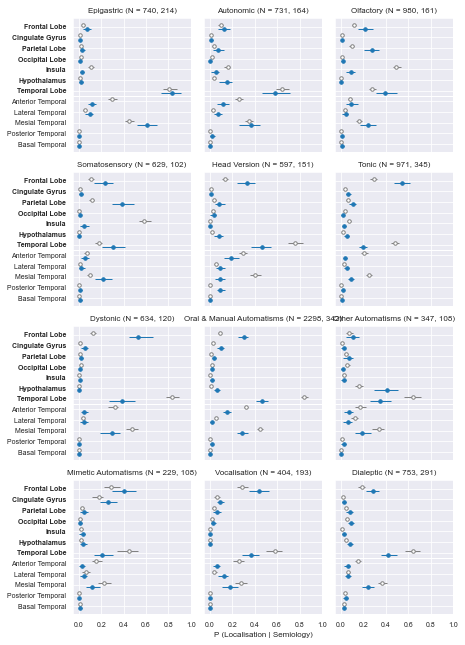

In [270]:
sns.set_style("darkgrid")
reload(plotter)

fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results['spontaneous']['proportion'],
                               confint_df_2 = results['spontaneous']['confints'],
                               counts_df_2 = results['spontaneous']['counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping = False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1],
                               xticks = np.arange(0, 1.01, 0.2),
#                                n= options - can omit. N=Datapoints. n=#of semiologies.
#                                fontsize=7,
                               special_y_titles = special_y_index,
                                figsize = (6.5, 9),
                              )
# localising_n = query_results, 
# plt.legend('bottom_right')
# plt.savefig(f'scripts/figures/working_figures_4/normalised_v2.png', dpi=300, pad_inches=0.5)
# plt.savefig(repo_dir / 'images' / 'Brain' / 'test_fig-1_raw_10-bootstrap_zone.eps', dpi=300, pad_inches=0.5)

_______
# Figure 2: By zone
________

In [295]:
results = {}
reload(interogate_queries)
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names_re,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = semiology_list,
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = True,
        confint_method = 'bootstrap',
        bootstrapping_samples = 1000, 
    order_of_regions = order_of_interest)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:414: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [296]:
results['full']['proportion']

,FL,CING,PL,OL,INSULA,Hypothalamus,TL,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG)
Epigastric,0.013270,0.012983,0.018726,0.028781,0.046615,0.023464,0.072539,0.073429,0.060100,0.076120,0.007714,0.033418
Fear-Anxiety,0.023557,0.080666,0.006925,0.007860,0.029554,0.000000,0.014019,0.009357,0.012886,0.017140,0.000000,0.040688
Psychic,0.007875,0.024096,0.012638,0.013447,0.009550,0.000000,0.055786,0.069098,0.025775,0.053011,0.022871,0.008256
Autonomic,0.034590,0.014680,0.039321,0.025747,0.067227,0.136440,0.057260,0.064568,0.029711,0.058190,0.025265,0.009121
Olfactory,0.051854,0.022477,0.150309,0.029269,0.279316,0.000000,0.032814,0.025951,0.055969,0.034774,0.014932,0.016170
Gustatory,0.001752,0.004141,0.002987,0.000000,0.010621,0.000000,0.005486,0.006205,0.005264,0.005270,0.000000,0.000000
Auditory,0.005682,0.002067,0.004472,0.004230,0.027565,0.000000,0.011735,0.008088,0.041320,0.009574,0.032125,0.000000
Visual,0.002761,0.006528,0.043941,0.184790,0.000558,0.000000,0.012354,0.009731,0.017823,0.012753,0.035661,0.015448
Somatosensory,0.033088,0.015004,0.115931,0.008772,0.210534,0.000000,0.013559,0.014726,0.007176,0.014009,0.006974,0.007553
Vestibular,0.001863,0.004404,0.033351,0.011265,0.036145,0.000000,0.007025,0.004729,0.027514,0.005815,0.000000,0.000000


<Figure size 432x288 with 0 Axes>

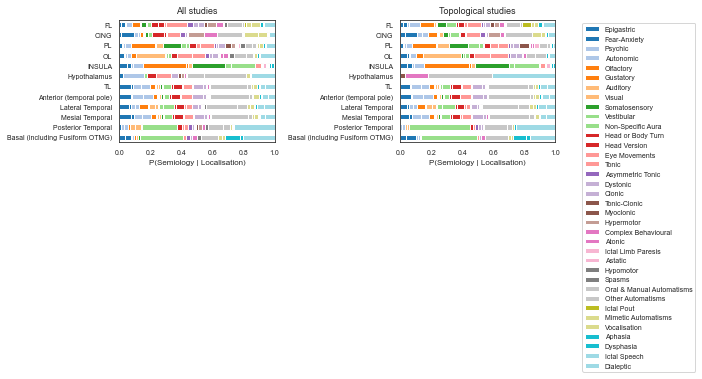

In [303]:
axis = 'zone'

sns.set_style('white')
sns.despine(left=True)
counts_form = 'raw_counts'

y_sums_1 = [int(n) for n in results['full'][counts_form].sum(0)]
y_sums_2 = [int(n) for n in results['topology'][counts_form].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, labels.clean_localisations(results['full']['counts'].columns))]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

color_palette =  sns.color_palette("tab20", 
                                    as_cmap=True
                                    )
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)
plotter.plot_stacked_hbar(results['full']['proportion'],
                          ax=axs[0],
                          ax_title='All studies',
                          axis=axis,
                          color_palette=color_palette, )
#                          special_y_titles = special_y_index)

plotter.plot_stacked_hbar(results['topology']['proportion'],
                          ax=axs[1],
                          ax_title='Topological studies',
                          axis=axis,
                          color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(results['full']['proportion'].index))

# axs[0].set_yticklabels(combine_labels_1[::-1])
# axs[1].set_yticklabels(n_labels_2[::-1])

plt.tight_layout()
# plt.savefig(f'scripts/figures/working_f

In [304]:
melted = results['full']['proportion'].reset_index().melt(id_vars=['index'], var_name=['localisation'])

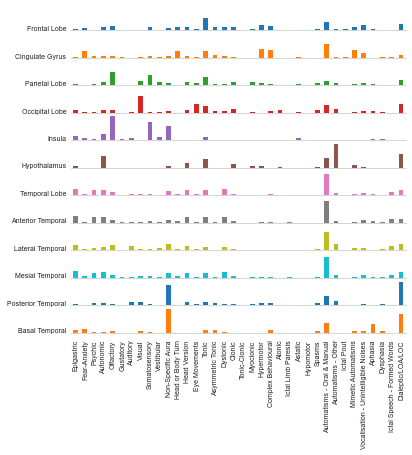

In [306]:
sns.set_style("whitegrid")
axs = results['full']['proportion'].plot(kind='bar', subplots=True, sharey=True, 
              figsize=(6, 6), legend=False, yticks=[], 
              grid=False, ylim=(0, 0.27), edgecolor='none')

sns.despine(left=True)
for ax in axs:
    ax.set_title('')
    sername = ax.get_legend_handles_labels()[1][0]
    ax.text(-1, 0, labels.clean_localisations(sername)[0], fontsize=7, ha='right')

plt.subplots_adjust(wspace = 0.001, hspace = 0.15)
# plt.tight_layout()
# plt.savefig(f'scripts/figures/working_figures_2/fig-2/bar/panel_bar.png', dpi=300, pad_inches=3)

In [307]:
# results = {}
# reload(interogate_queries)
# for study_type, query_result in query_results.items():
#     result = interogate_queries.summarise_query(
#         query_result,
#         axis = 'zone',
#         region_names = region_names,
#         normalise = True,
#         temporal_status = 'both',
#         semiologies_of_interest = core_semiologies,
#         drop_other_semiology = True,
#         merge_other_regions = True,
#         drop_other_regions = False,
#         confint_method = 'bootstrap',
#         bootstrapping_samples = 1000, 
#     order_of_regions = order_of_interest)
    
#     results[study_type] = result

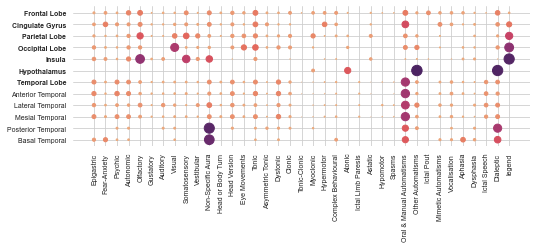

In [309]:
counts_form = 'counts'
results_form = 'topology'
df = copy.deepcopy(results[results_form]['proportion'])
df.loc['legend'] = np.zeros(df.shape[1])
df.iloc[-1,0] = 0.01
df.iloc[-1,1] = 0.1
df.iloc[-1,2] = 0.2
df.iloc[-1,3] = 0.3
df.iloc[-1,4] = 0.4

x = list(range(df.shape[0]))*df.shape[1]
y = []
for i in range(df.shape[1]):
    y += [i]*df.shape[0]

s = df.T.values.flatten() 

y_sums_1 = [int(n) for n in results[results_form][counts_form].sum(0)]
combine_labels_1 = [label+f' ({n})' for n, label in zip(y_sums_1, labels.clean_localisations(df.columns))]
n_labels_1 = [f'{n}' for n in y_sums_1]

sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize=(7.5, 4))
scatter = plt.scatter(x,
            y,
            s=s*260,
            c=s,
            cmap='flare',
            )
# labels.clean_localisations(df.columns)
plt.yticks(range(df.shape[1]), labels.clean_localisations(df.columns))
plt.xticks(range(df.shape[0]), labels.clean_semiologies(df.index), rotation=90)

axs.invert_yaxis()

special_y_titles = special_y_index
inverse_special_titles = [f for f in range(results['full']['proportion'].shape[0]) if f not in special_y_titles]
for y in special_y_titles:
    axs.get_yticklabels()[y].set_weight("bold")
for y in inverse_special_titles:
    # axs[ax_n, 0].get_yticklabels()[y].set_color("dimgrey")
    pass

plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.gca().set_aspect("equal")

# plt.legend(*scatter.legend_elements("colors", num=5))
# handles, label = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = axs.legend(handles, label, loc="upper right", title="Sizes")

# plt.savefig(f'scripts/figures/working_figures_3/fig-2/topology/topology_labels_key.png', dpi=300, pad_inches=0.5)

AttributeError: 'silent_list' object has no attribute 'set_weight'

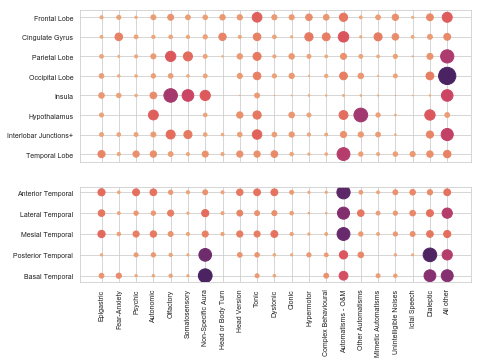

In [334]:
df_1 = results['full']['proportion'].iloc[:,:8]
df_2 = results['full']['proportion'].iloc[:,8:]

sns.set_style('whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharey=False, sharex=True, gridspec_kw={'height_ratios': [8, 5]})

for ax_n, df in enumerate([df_1, df_2]):
    x = list(range(df.shape[0]))*df.shape[1]
    y = []
    for i in range(df.shape[1]):
        y += [i]*df.shape[0]
        
    s = df.T.values.flatten()    
    
    axs[ax_n].scatter(x,
                y,
                s=s*700,
                c=s,
                cmap='flare',
                )
    
    plt.sca(axs[ax_n])
    plt.yticks(range(df.shape[1]), labels.clean_localisations(df.columns))
    plt.xticks(range(df.shape[0]), labels.clean_semiologies(df.index), rotation=90)
    axs[ax_n].invert_yaxis()

axs[0].get_yticklabels().set_weight("bold")

#     special_y_titles = special_y_index
#     inverse_special_titles = [f for f in range(results['full']['proportion'].shape[0]) if f not in special_y_titles]
#     for y in special_y_titles:
#         axs.get_yticklabels()[y].set_weight("bold")
#     for y in inverse_special_titles:
#         # axs[ax_n, 0].get_yticklabels()[y].set_color("dimgrey")
#         pass

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures_2/fig-2/heatmap/heat_size_map_split.eps', dpi=300, pad_inches=0.5)

# spearman's for brain ROIs: Generative similarity ?structutal and functional connectivity

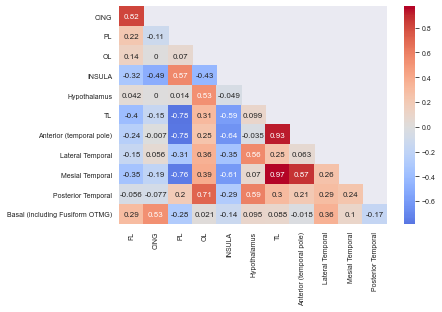

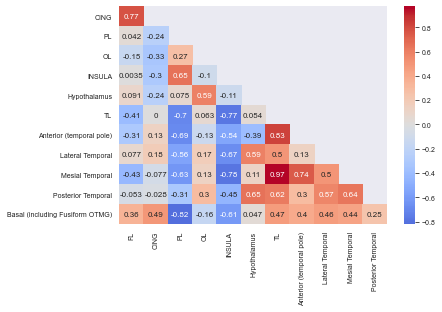


 correlation between all and TS
FL 0.008239768712338441
CING 0.0003316683391269209
PL 0.0022231354099909208
OL 0.011374198642690932
INSULA 0.0003547590073493126
Hypothalamus 0.020781098744326612
TL 0.0034464502618274493
Anterior (temporal pole) 0.000521133700481005
Lateral Temporal 9.5435818268384e-07
Mesial Temporal 0.00041811794041499725
Posterior Temporal 0.00035903023787490015
Basal (including Fusiform OTMG) 0.0001343354722529837


In [330]:
# spearman's for brain ROIs

df_ROI_all = results['full']['proportion']
df_ROI_TS = results['topology']['proportion']

# # check distributions
# sns.jointplot(x="FL", y="PL", data=df_ROI_all, alpha=0.4)
# sns.jointplot(x="CING", y="FL", data=df_ROI_TS, alpha=0.4, color='red')
# plt.show()

# correlations
corr_all = df_ROI_all.corr(method = 'spearman')
corr_TS = df_ROI_TS.corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_all, dtype=bool))
mask = mask[1:, :-1]
corr_all_diag = corr_all.iloc[1:,:-1].copy()
corr_TS_diag = corr_TS.iloc[1:,:-1].copy()

a = sns.heatmap(corr_all_diag, annot = True, cmap='coolwarm', center=0, mask=mask)
plt.yticks(rotation=0)
plt.show()
sns.heatmap(corr_TS_diag, annot = True, cmap='coolwarm', center=0, mask=mask)
plt.savefig(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TS.png', dpi=300, pad_inches=0.5)
plt.show()

# check the correlation between the all and TS dataframes
from scipy.stats import spearmanr
print('\n correlation between all and TS')
for lobe in df_ROI_all:
    r, p = spearmanr(df_ROI_all[lobe], df_ROI_TS[lobe])
    print (lobe, p) #  hypothalamus has the biggest change from all to TS with p=0.014 with bonferroni, FL is also not correlated (p>0.05/8+) ie changes from all to TS

# corr_all
corr_TS.to_csv(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TSfilter.csv')

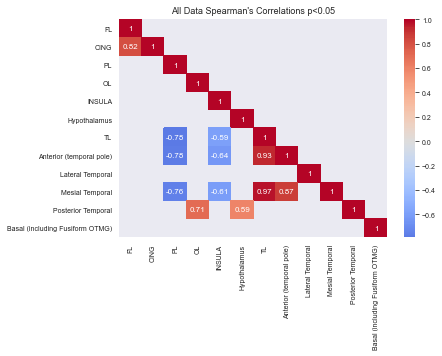

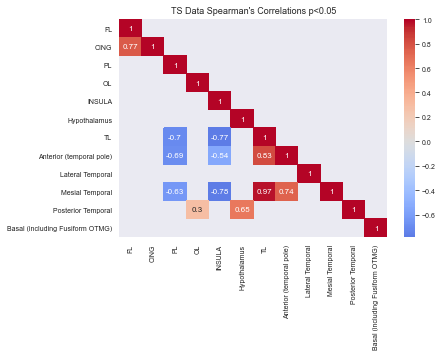

In [331]:
# only significant associations:

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# get p values and mask
p_values_all = corr_sig(df_ROI_all)
mask_all = np.invert(np.tril(p_values_all<0.05))
p_values_TS = corr_sig(df_ROI_all)
mask_TS = np.invert(np.tril(p_values_TS<0.05))

# plot with mask
corr_all = df_ROI_all.corr(method = 'spearman')
a = sns.heatmap(corr_all, annot = True, cmap='coolwarm', center=0, mask=mask_all)
plt.title("All Data Spearman's Correlations p<0.05")
plt.yticks(rotation=0)
plt.show()

corr_TS = df_ROI_TS.corr(method = 'spearman')
sns.heatmap(corr_TS, annot = True, cmap='coolwarm', center=0, mask=mask_TS)
plt.title("TS Data Spearman's Correlations p<0.05")
plt.savefig(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TS_significant.png', dpi=300, pad_inches=0.5)
plt.show()

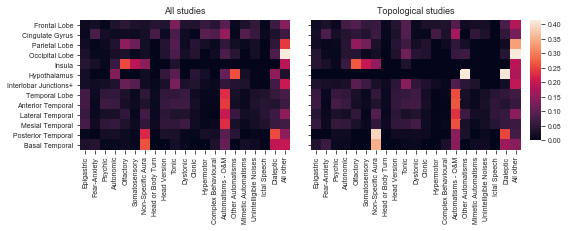

In [278]:
sns.set_style('ticks')
fig, axs = plt.subplots(1, 2, figsize=(7.5, 2.9), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.99, .38, .02, 0.576])
cbar_ax.patch.set_edgecolor('black')  
cbar_ax.patch.set_linewidth('1')  
plt.tight_layout()

heatmap_kwargs = {
    'square': True,
#      'xticklabels': x_labels
#     'vmin': 0.0,
#     'vmax': 1.0,
}

sns.heatmap(results['full']['proportion'].T, ax=axs[0], cbar=False, **heatmap_kwargs)
sns.heatmap(results['topology']['proportion'].T, ax=axs[1], cbar=True, cbar_ax = cbar_ax, **heatmap_kwargs)

axs[0].set_yticklabels(labels.clean_localisations(results['topology']['proportion'].columns), rotation=0)
axs[0].set_xticklabels(labels.clean_semiologies(results['topology']['proportion'].index))
axs[0].set_title('All studies')
axs[1].set_title('Topological studies')

# fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures_2/fig-2/heatmap/heatmap.eps', dpi=300, pad_inches=0.5)

# 2b - Region-specific subplots

- Q - use full, SS or topology?
- ***NOT RIGHT - NEEDS TO BE REWRTTTEN WITH NEW NORMALISATION

In [663]:
def get_specific_df(query_results, columns_of_interest):
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [34]:
axis = 'zone'
normalised_or_not = 'normalised'

In [35]:
#Cingulate
cing_processed_dfs = {}
columns_of_interest = ['CING', 'Ant Cing (frontal, genu)', 'Post Cing', ]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['Cingulate - (anterior + posterior)'] = counts_df['CING'] - (counts_df['Post Cing'] + counts_df['Ant Cing (frontal, genu)'])
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    cing_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: invalid value encountered in sqrt
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


In [36]:
# SMA
sma_processed_dfs = {}
columns_of_interest = ['SSMA', 'SMA (pre-central gyrus; posterior SFG, MFG)', 'FL']
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['SMA'] = counts_df['SSMA'] + counts_df['SMA (pre-central gyrus; posterior SFG, MFG)']
    counts_df['FL-SMA'] = counts_df['FL'] - counts_df['SMA']
    counts_df = counts_df.drop(['SMA (pre-central gyrus; posterior SFG, MFG)', 'SSMA'], 1)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    sma_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

In [37]:
# PL
pl_processed_dfs = {}
columns_of_interest = ['PL',
                       'Primary Sensory Cortex (post-central gyrus)',
                       'medial anterior parietal',
                       'Sup. pariet. lobule',
                       'Inferior Parietal Lobule',]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    pl_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

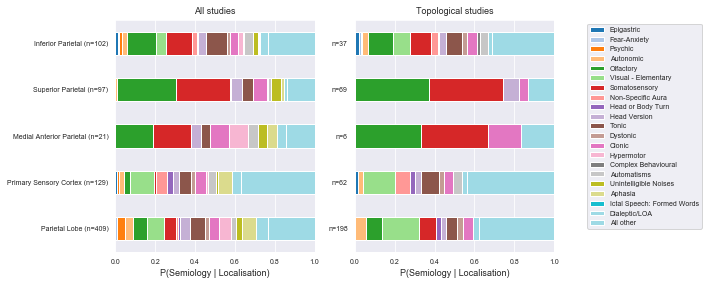

In [39]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 2.5))

#Choose from {cing_processed_dfs, pl_processed_dfs, sma_processed_dfs}
processed_dfs = copy.deepcopy(pl_processed_dfs)

y_labels = labels.clean_localisations(processed_dfs['full']['counts'].columns)
y_sums_1 = [int(n) for n in processed_dfs['full']['counts'].sum()]
y_sums_2 = [int(n) for n in processed_dfs['topology']['counts'].sum()]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All studies', axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['topology']['proportion'], ax=axs[1], ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[0].set_yticklabels(combine_labels_1)
axs[1].set_yticklabels(n_labels_2)
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs['topology']['proportion'].index))

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/PL.png', dpi=300, pad_inches=0.5)

---
# Figure 3: Odds ratio
---

Odds of semiology 1 localising to lobe A, divided by odds of NotSemiology A localising to lobe A. NotSemiology can be obtained by removing the result of QUERY_SEMIOLOGY from the original_df.
This gives Relative localising values. Interpret as intrinsic values of a specific semiology vs other semiologies. Narrow clinical history question.

In [310]:
def odds_ratio_df(counts, total_row, log_odds=False):
    melted = counts.reset_index().melt(id_vars='index')
    melted = melted.rename(columns={'index': 'semiology', 'variable': 'localisation', 'value': 'a'})
    melted['localisation_total'] = np.zeros(len(melted))
    for localisation, total in total_row.to_dict().items():
        mask = melted['localisation'] == localisation
        melted.loc[mask, 'localisation_total'] = total
        
    melted['c'] = melted['localisation_total'] - melted['a']
    
    melted['semiology_total'] = np.zeros(len(melted))
    for semiology, total in counts.sum(1).to_dict().items():
        mask = melted['semiology'] == semiology
        melted.loc[mask, 'semiology_total'] = total
        
    melted['b'] = melted['semiology_total']-melted['a']
    
    melted['d'] = np.repeat(total_row.sum(), len(melted)) - (melted['a'] + melted['b'] + melted['c'])
    
    melted['OR'] = np.nan
    melted['OR_lower_ci'] = np.nan
    melted['OR_upper_ci'] = np.nan
    
    for i in melted.index:
        contingency_table = Table2x2(
        [[melted.loc[i, 'a'], melted.loc[i, 'b']],
         [melted.loc[i, 'c'], melted.loc[i, 'd']]] )
        
        if not log_odds:
            melted.loc[i, 'OR'] = contingency_table.oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[1]
        else:
            melted.loc[i, 'OR'] = contingency_table.log_oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.log_oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.log_oddsratio_confint(alpha = 0.05)[1]

    or_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR')
    or_l_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_lower_ci')
    or_u_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_upper_ci')
    
    or_dfs = {
        'counts': counts,
        'or': or_pivot,
        'confints': (or_l_pivot, or_u_pivot)
    }
    
    return or_dfs

In [77]:
order = ['Anterior (temporal pole)',
             'Lateral Temporal',
             'Mesial Temporal',
             'Posterior Temporal',
             'Basal (including Fusiform OTMG)',
             'Hypothalamus',
             'PL',
             'CING',
             'OL',
             'FL',
             'INSULA',
             'All other',
             ]

In [312]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology', # or'zone'
        region_names = region_names_re,
        normalise = normalised,
        temporal_status = 'both',
        semiologies_of_interest = semiologies_100,
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = True,
        confint_method = 'bootstrap',
        bootstrapping_samples = 1000, 
        order_of_regions = order_of_interest)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:414: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [313]:
normalised = True
if normalised:
    count_type = 'counts'
    row_type = 'normalised_row'
else:
    count_type = 'raw_counts'
    row_type = 'raw_row'

In [314]:
total_rows = {}
for study_type in all_dfs.keys():
    total_row = all_dfs[study_type][region_names_re['low_level_temporal_of_interest'] + region_names_re['top_level']].sum()
    top_level_sums = all_dfs[study_type][region_names_re['top_level']].sum()
    temporal_sums = all_dfs[study_type][region_names_re['low_level_temporal_of_interest']].sum()
    
    localising_sum = all_dfs[study_type]['Localising'].sum()
    top_level_ratio = localising_sum/top_level_sums.sum()
    top_level_normalised = top_level_ratio*top_level_sums

    temporal_ratio = top_level_normalised['TL'] / temporal_sums.sum()
    temporal_normalised = temporal_ratio * temporal_sums
    normalised_row = pd.concat([temporal_normalised, top_level_normalised])
    total_rows[study_type] = {
        'raw_row': total_row,
        'normalised_row': normalised_row
    }

In [328]:
odds_dfs = {}
for data_type in ['full', 'spontaneous']:
    odds_dfs[data_type] = odds_ratio_df(results[data_type][count_type], total_rows[data_type][row_type], log_odds = False)
    odds_dfs[data_type] = interogate_queries.order_regions(odds_dfs[data_type], order_of_interest)    

(<Figure size 504x648 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'Oral & Manual Automatisms (N = 2298, 342)'}>,
         <AxesSubplot:title={'center':'Other Automatisms (N = 347, 108)'}>,
         <AxesSubplot:title={'center':'Autonomic (N = 731, 164)'}>],
        [<AxesSubplot:title={'center':'Dialeptic (N = 753, 291)'}>,
         <AxesSubplot:title={'center':'Dystonic (N = 634, 120)'}>,
         <AxesSubplot:title={'center':'Epigastric (N = 740, 214)'}>],
        [<AxesSubplot:title={'center':'Head Version (N = 597, 151)'}>,
         <AxesSubplot:title={'center':'Mimetic Automatisms (N = 229, 108)'}>,
         <AxesSubplot:title={'center':'Olfactory (N = 980, 161)'}>],
        [<AxesSubplot:title={'center':'Somatosensory (N = 629, 102)'}>,
         <AxesSubplot:title={'center':'Tonic (N = 971, 345)'}, xlabel='Odds ratio'>,
         <AxesSubplot:title={'center':'Vocalisation (N = 404, 193)'}>]],
       dtype=object))

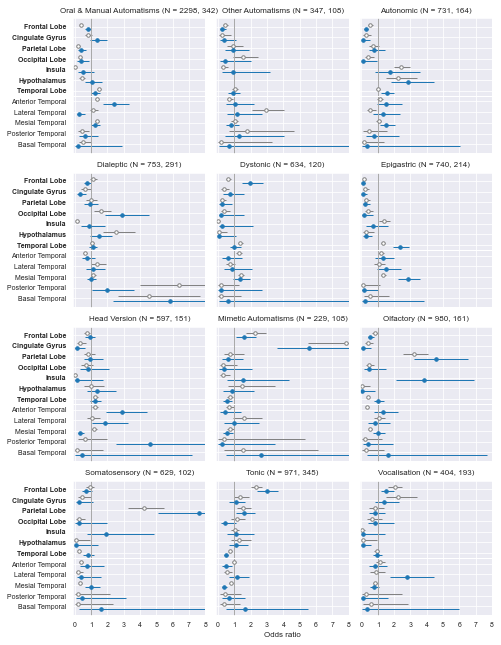

In [329]:
sns.set_style('darkgrid')
reload(plotter)
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'],
    confint_df_1 = [df for df in odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'],
    confint_df_2 = [df for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'].index),
    xlim = [-0.1,8], 
    xticks = np.arange(-1, 9, 1),
    vline = 1.0,
    xlabel = 'Odds ratio',
    figsize = (7, 9),
    plotter_settings = plotter_settings,
    special_y_titles = special_y_index,
)
    
# plt.savefig(f'scripts/figures/working_figures_3/fig-3/raw.png', dpi=300, pad_inches=0.5)

## TL as a single category

In [33]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = True,
        merge_temporal = True,
        semiologies_of_interest = sorted_semiologies[-12:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:164: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [48]:
total_row = all_dfs['full'][region_names['of_interest']].sum()
total_row['All other'] = all_dfs['full'][region_names['top_level_all_other']].sum().sum()
odds_dfs = {}
odds_dfs['full'] = odds_ratio_df(results['full']['counts'], total_row, log_odds = False)
odds_dfs['spontaneous'] = odds_ratio_df(results['spontaneous']['counts'], total_row, log_odds = False)

(<Figure size 504x576 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c38a2e0>,
       dtype=object))

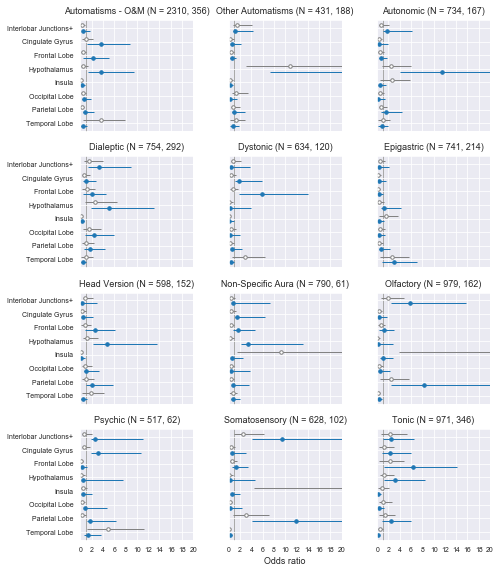

In [49]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'],
    confint_df_1 = [df for df in odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'],
    confint_df_2 = [df for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'].index),
    xlim = [-0.05,20],
    xticks = np.arange(0, 21, 2),
    vline = 1.0,
    xlabel = 'Odds ratio',
#     figsize = (7, 9),
    plotter_settings = plotter_settings,
)

# plt.savefig(f'scripts/figures/working_figures/fig-3/normalised_top_level.eps', dpi=300, pad_inches=0.5)

# NMI/Correlation

In [709]:
import dython

In [765]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names,
        normalise = True,
        merge_temporal = False,
        semiologies_of_interest = sorted_semiologies[-20:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    
    results[study_type] = result

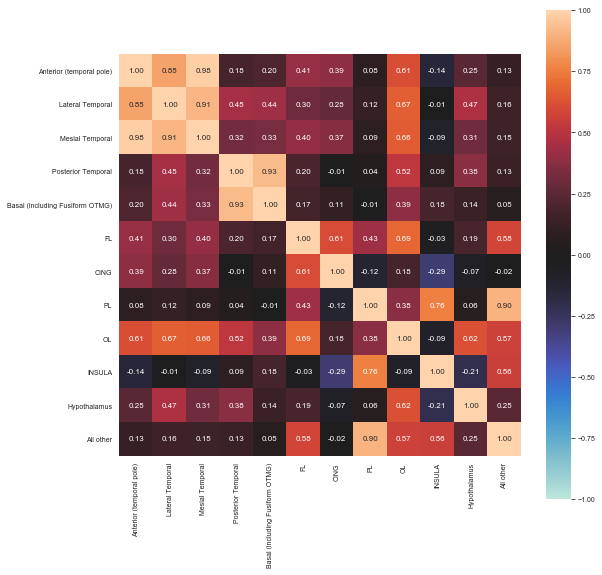

<Figure size 432x288 with 0 Axes>

In [766]:
dython.nominal.associations(results['full']['counts'], theil_u=True, figsize=(9, 9))
plt.tight_layout()

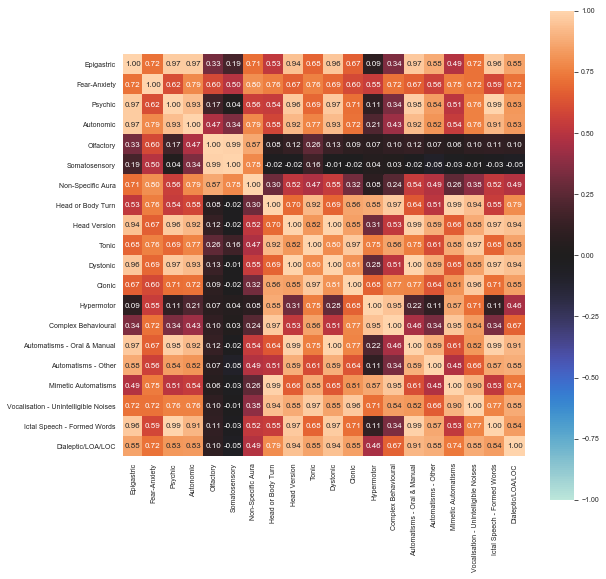

<Figure size 432x288 with 0 Axes>

In [767]:
dython.nominal.associations(results['full']['counts'].T, theil_u=True, figsize=(9, 9))
plt.tight_layout()